<img src="https://www.unad.edu.co/images/footer/logo-unad-acreditacion-min.png" width="680" height="140" align="right"/>

<h4 style="text-align: center;">Curso: Métodos estadísticos</h4>
<h4 style="text-align: center;">Tarea: Unidad 3</h4>
<h4 style="text-align: center;">Presentado por: Oscar Andrés Russi Porras</h4>
<h4 style="text-align: center;">Universidad Nacional Abierta y a Distancia – UNAD</h4>
<h4 style="text-align: center;">Fecha: noviembre de 2024</h4>


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import pearsonr
import datetime
from IPython.display import display
from sklearn.decomposition import PCA

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.stats import chi2_contingency
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
import random
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import tree

In [17]:
import urllib
from sqlalchemy import create_engine
import pandas as pd

params = urllib.parse.quote_plus(
    "DRIVER={SQL Server};"
    "SERVER=DESKTOP-KNKLQ23\MSSQLSERVER01;DATABASE=inmuebles;"
    "UID=oscarrussi;PWD=a1s2d3f4;"
)

# "mssql+pyodbc" es el dialecto para SQL Server a través de pyodbc
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [18]:
query = "select * from dbo.datosVivienda where (price is not null and price<>'') and (ubicacion is not null and ubicacion<>'')"
df = pd.read_sql(query, engine)

print(df.head())

            price  habitaciones  \
0    120000000.00          2.00   
1    105000000.00          1.00   
2   7850000000.00          1.00   
3  22000000000.00          1.00   
4 107158800000.00           NaN   

                                              descr  \
0                              Apartamento en venta   
1              Edificio en venta, Bogotá - Germania   
2  Edificio en venta, Bogotá - Primavera Occidental   
3                                   Bodega en venta   
4                                     Lote en venta   

                                                link  banyos       id  \
0  https://www.fincaraiz.com.co/apartamento-en-ve...    1.00  2351795   
1  https://www.fincaraiz.com.co/edificio-en-venta...     NaN  3056432   
2  https://www.fincaraiz.com.co/edificio-en-venta...    2.00  3072117   
3  https://www.fincaraiz.com.co/bodega-en-venta/3...     NaN  3129789   
4  https://www.fincaraiz.com.co/lote-en-venta/314...     NaN  3149801   

  tipoInmueble   es

In [19]:
pd.set_option('display.float_format', '{:.2f}'.format)
main_columns=["price","habitaciones","banyos","estrato","areaConstruida","areaPrivada","parqueaderos","administracion","pisoNumero","totalPisos"]
summary = df[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,5925.00,4850.00,5183.00,5829.00,5846.00,4866.00,3501.00,2862.00,3205.00,2618.00
mean,36160532015.92,2.96,2.75,3.97,167.17,153.45,2.98,3409852.42,4.25,2.82
std,1253796483218.73,6.24,2.44,1.39,204.05,203.63,4.75,53347225.06,3.93,3.65
min,1000.00,0.00,0.00,1.00,0.00,0.00,-1.00,0.00,0.00,0.00
25%,210000000.00,2.00,1.00,3.00,47.00,40.00,1.00,156000.00,1.00,0.00
50%,470000000.00,3.00,2.00,4.00,79.00,70.84,2.00,342000.00,4.00,2.00
75%,1420000000.00,3.00,3.00,5.00,195.00,173.75,3.00,735000.00,6.00,5.00
max,95000000000000.00,400.00,60.00,7.00,998.00,998.00,127.00,2000000000.00,21.00,21.00


In [20]:
trash_columns = ['descr', 'link','id']
df_nuevo = df.drop(columns=trash_columns)
df_nuevo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5925 entries, 0 to 5924
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   price           5925 non-null   float64       
 1   habitaciones    4850 non-null   float64       
 2   banyos          5183 non-null   float64       
 3   tipoInmueble    5911 non-null   object        
 4   estadoInmueble  5911 non-null   object        
 5   areaConstruida  5846 non-null   float64       
 6   areaPrivada     4866 non-null   float64       
 7   antiguedad      5925 non-null   object        
 8   parqueaderos    3501 non-null   float64       
 9   administracion  2862 non-null   float64       
 10  pisoNumero      3205 non-null   float64       
 11  totalPisos      2618 non-null   float64       
 12  comodidades     4889 non-null   object        
 13  ubicacion       5925 non-null   object        
 14  estrato         5829 non-null   float64       
 15  date

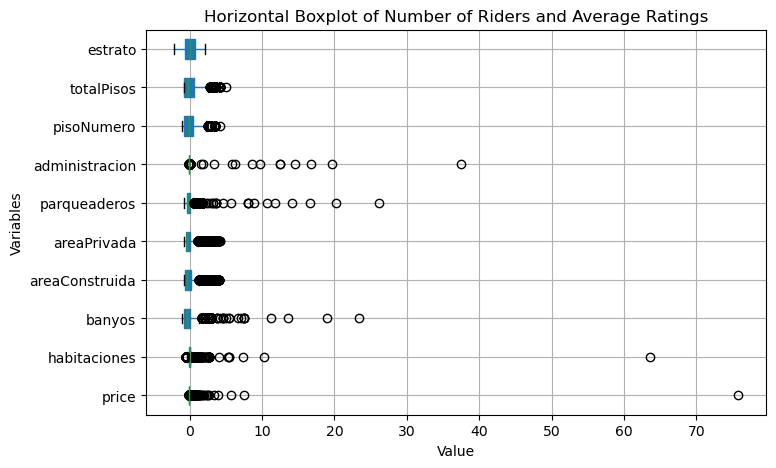

In [21]:
def clasificar_variable(tipo):
    if pd.api.types.is_numeric_dtype(tipo):
        return 'Numérica'
    elif pd.api.types.is_string_dtype(tipo):
        return 'Categórica'
    else:
        return 'Otra'



def create_box(df_):
    numerics = [num for num in df_.columns if clasificar_variable(df_[num].dtype)=='Numérica']
    scaler = StandardScaler()
    # Create a copy of the DataFrame and normalize the selected columns
    df_normalized = df_[numerics].copy()
    df_normalized[numerics] = scaler.fit_transform(df_[numerics])
    # Create the horizontal boxplot
    plt.figure(figsize=(8, 5))
    df_normalized.boxplot(vert=False, patch_artist=True)
    # Set the title, labels, and y-ticks
    plt.title('Horizontal Boxplot of Number of Riders and Average Ratings')
    plt.xlabel('Value')
    plt.ylabel('Variables')
    plt.yticks(ticks=range(1, len(numerics) + 1), labels=numerics)  # Set labels based on column names
    plt.grid(True)
    plt.show()

create_box(df_nuevo)

In [22]:
mapa_antiguedad = {
    "menor a 1 año": 1,
    "1 a 8 años": 2,
    "9 a 15 años": 3,
    "16 a 30 años": 4,
    "más de 30 años": 5,
    "¡Pregúntale!": np.nan  # por ejemplo, puedes marcarlo como NaN
}

df_nuevo["antiguedad"] = df_nuevo["antiguedad"].replace(mapa_antiguedad)
df_nuevo.sample(5)

,price,habitaciones,banyos,tipoInmueble,estadoInmueble,areaConstruida,areaPrivada,antiguedad,parqueaderos,administracion,pisoNumero,totalPisos,comodidades,ubicacion,estrato,date_created,date_modified
1034,5801000.00,6.00,8.00,Casa,¡Pregúntale!,361.54,289.00,2,5.00,NaN,NaN,NaN,None,"Chicó Alto, Bogotá, Bogotá, d.c.",6.00,NaT,2025-03-23 09:53:10.803
730,10300000000.00,NaN,7.00,Lote,¡Pregúntale!,900.00,NaN,4,11.00,NaN,NaN,NaN,•Cerca centro comercial•Cocineta•Tanques de Ag...,"Navarra, Bogotá, Bogotá, d.c.",6.00,NaT,2025-03-23 09:53:41.587
5609,307000000.00,3.00,2.00,Apartamento,¡Pregúntale!,67.00,67.00,5,1.00,0.00,16.00,0.00,•Ascensor•Barra estilo americano•Baño Independ...,"Suba, Bogotá, Bogotá, d.c.",3.00,2025-03-27 08:29:09.247,2025-03-27 10:22:29.890
331,20000000000.00,1.00,4.00,Oficina,¡Pregúntale!,565.00,565.00,3,11.00,NaN,NaN,NaN,•Aire Acondicionado•Alarma Contra Incendio•Asc...,"El retiro, Bogotá, Bogotá, d.c.",6.00,NaT,2025-03-23 09:53:10.803
5700,390000000.00,0.00,0.00,Oficina,¡Pregúntale!,44.00,44.00,2,1.00,NaN,0.00,0.00,•Acceso Pavimentado•Ascensor•Circuito cerrado ...,"Zona chapinero, Bogotá, Bogotá, d.c.",6.00,2025-03-28 08:39:37.453,2025-03-28 10:36:53.840


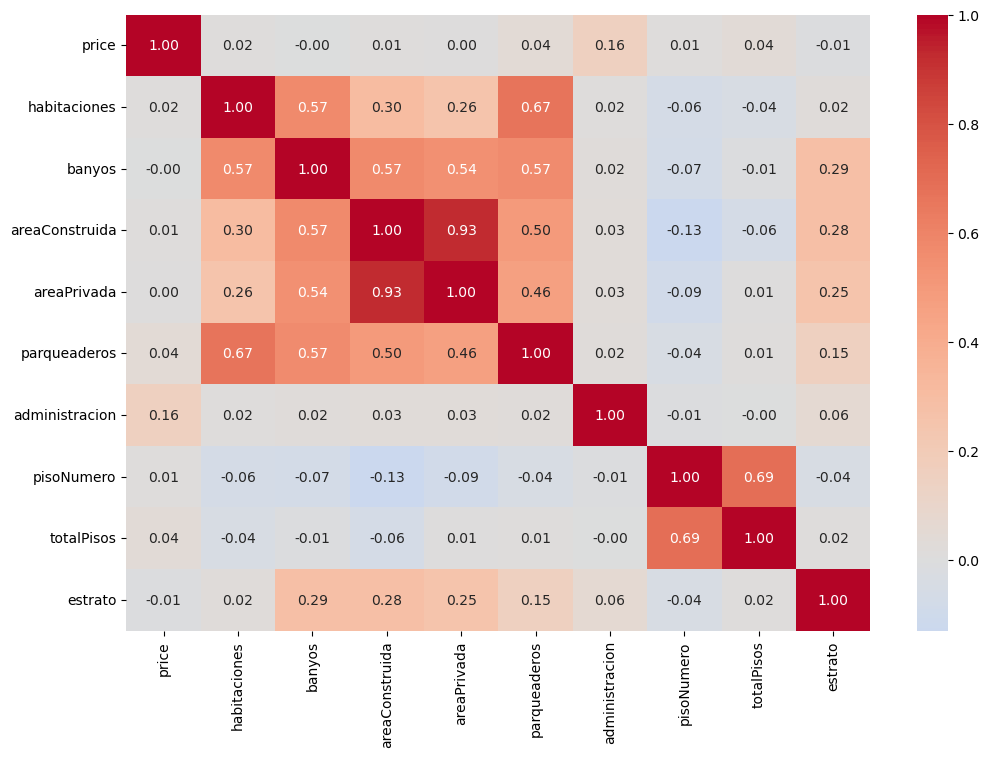

In [23]:
numerics = [num for num in df_nuevo.columns if clasificar_variable(df_nuevo[num].dtype)=='Numérica']

def corr_matrix(df_):
    # Assuming df_hotels_booking is your DataFrame and 'numerics' is a list of numeric columns
    correlation_matrix = df_[numerics].corr()
    # Set up the matplotlib figure
    plt.figure(figsize=(12, 8))
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.show()  # display the heatmap

corr_matrix(df_nuevo)

In [24]:
def clean_dataframe(df):
    # Columnas a revisar
    columns_to_check = ['price', 'habitaciones', 'banyos', 'estrato', 'areaConstruida',
                        'areaPrivada', 'parqueaderos', 'administracion', 'pisoNumero', 'totalPisos']

    # Eliminar filas con valores negativos en las columnas especificadas
    for col in columns_to_check:
        df = df[df[col] >= 0]

    # Eliminar filas con estrato mayor a 6
    df = df[df['estrato'] <= 6]
    
    # Reiniciar índice para mantener consistencia
    df.reset_index(drop=True, inplace=True)
    return df

df_nuevo=clean_dataframe(df_nuevo)
print("executed completed")

executed completed


Column: price, log skew factor: 4.782, mean: 14721468861.6, median: 565000000.0, IQR: 430000000.000, Q1: 420000000.000, Q3: 850000000.000
column: price, lower bound is 205337505.22656047, and upper_bound is 8790489293.410, subs left: 359662494.773, add right: 8225489293.410
Column: habitaciones, log skew factor: 0.952, mean: 2.7, median: 3.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: habitaciones, lower bound is -1.2001054193708134, and upper_bound is 6.809, subs left: 4.200, add right: 3.809
Column: banyos, log skew factor: 1.133, mean: 2.6, median: 2.0, IQR: 1.000, Q1: 2.000, Q3: 3.000
column: banyos, lower bound is -1.52986707197251, and upper_bound is 6.533, subs left: 3.530, add right: 4.533
Column: areaConstruida, log skew factor: 1.149, mean: 117.6, median: 88.0, IQR: 53.000, Q1: 69.000, Q3: 122.000
column: areaConstruida, lower bound is -96.49047361675466, and upper_bound is 331.611, subs left: 184.490, add right: 243.611
Column: areaPrivada, log skew factor: 1.122, mean: 101.0,

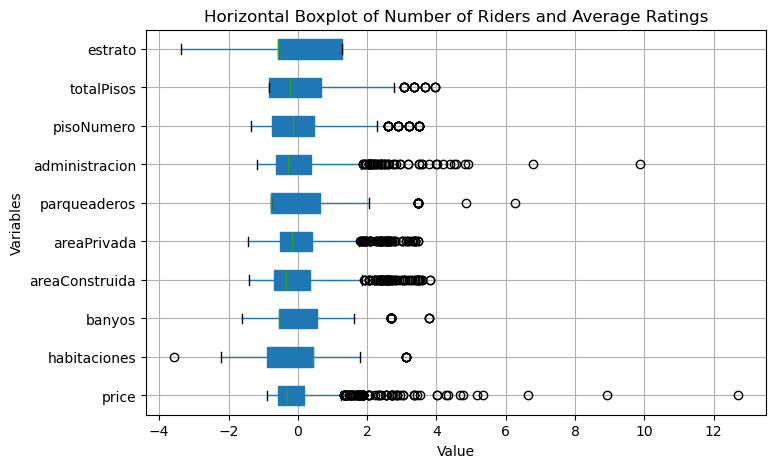

In [25]:
import numpy as np
import pandas as pd

def iqr_skew_adjusted_bounds(series,  factor=3.0):
    """
    Returns (lower_bound, upper_bound) for outlier detection
    using an IQR-based rule adjusted by a log-skew factor:
    
    lower_bound = Q1 - factor * IQR * (1 / log_skew_factor)
    upper_bound = Q3 + factor * IQR * log_skew_factor
    
    The log_skew_factor = log((mean * e) / median).
    """
    valid = series.dropna()
    if valid.empty:
        return -np.inf, np.inf  # no valid data
    
    Q1 = valid.quantile(0.29)
    Q3 = valid.quantile(0.71)
    IQR = Q3 - Q1
    
    mean_val = valid.mean()
    median_val = valid.median()

    # If median is zero or negative, or mean is NaN, fallback to standard IQR
    if median_val <= 0 or np.isnan(mean_val):
        return (Q1 - factor * IQR, Q3 + factor * IQR)
    
    # Compute the log-skew factor:
    # This equals 1 when mean == median (after factoring in e)
    log_skew_factor =  (mean_val / median_val)**0.48 # 1 #  np.log(mean_val * np.e / median_val) #
    print(f"Column: {series.name}, log skew factor: {log_skew_factor:.3f}, "
          f"mean: {mean_val:.1f}, median: {median_val:.1f}, IQR: {IQR:.3f}, Q1: {Q1:.3f}, Q3: {Q3:.3f}")

    # Adjust bounds
    subs_left= factor * IQR * (1 / log_skew_factor) if log_skew_factor != 0 else factor * IQR
    add_right= factor * IQR *  log_skew_factor
    lower_bound = median_val - subs_left
    upper_bound = median_val + add_right
    print(f"column: {series.name}, lower bound is {lower_bound}, and upper_bound is {upper_bound:.3f}, subs left: {subs_left:.3f}, add right: {add_right:.3f}")
    return lower_bound, upper_bound

def remove_outliers_iqr_skew_all(df, factor=3.0):
    """
    Applies the iqr_skew_adjusted_bounds to each numeric column in df.
    A row is removed if it is an outlier in ANY numeric column.
    Returns a new DataFrame with those rows removed.
    """
    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    
    # Start with a mask of all True
    mask = pd.Series(True, index=df.index)
    
    # For each numeric column, compute skew-adjusted IQR bounds, then refine the mask
    for col in numeric_cols:
        lb, ub = iqr_skew_adjusted_bounds(df[col], factor=factor)
        
        # Keep rows that are NaN or within [lb, ub]
        col_mask = df[col].isna() | ((df[col] >= lb) & (df[col] <= ub))
        mask &= col_mask  # logical AND: row must be non-outlier in ALL numeric cols
    
    # Return filtered DataFrame
    return df[mask].reset_index(drop=True)

df_no_outliers = remove_outliers_iqr_skew_all(df_nuevo, factor=4)
create_box(df_no_outliers)

In [26]:
summary = df_no_outliers[main_columns]
summary_statistics = summary.describe(include='all')

# Display summary statistics
summary_statistics

,price,habitaciones,banyos,estrato,areaConstruida,areaPrivada,parqueaderos,administracion,pisoNumero,totalPisos
count,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00,1149.00
mean,744746673.99,2.67,2.50,4.62,105.47,89.16,1.55,654615.61,4.46,2.80
std,611118655.20,0.75,0.93,1.08,56.16,62.64,0.71,558513.30,3.30,3.33
min,209000000.00,0.00,1.00,1.00,27.00,0.00,1.00,0.00,0.00,0.00
25%,390000000.00,2.00,2.00,4.00,67.00,57.00,1.00,304000.00,2.00,0.00
50%,550000000.00,3.00,2.00,4.00,86.00,78.00,1.00,498000.00,4.00,2.00
75%,850000000.00,3.00,3.00,6.00,125.00,115.00,2.00,860000.00,6.00,5.00
max,8500000000.00,5.00,6.00,6.00,320.00,307.00,6.00,6170000.00,16.00,16.00


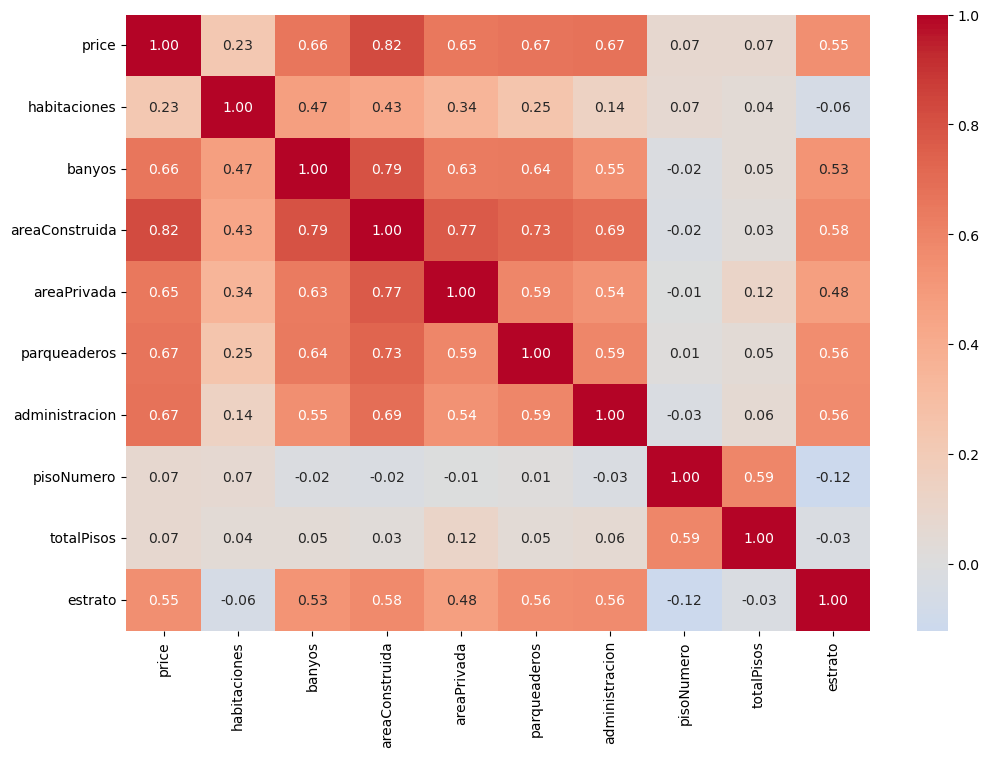

In [27]:
corr_matrix(df_no_outliers)

In [31]:
dummy_columns =["tipoInmueble", "estadoInmueble", "ubicacion"]
df_encoded = pd.get_dummies(
    df_normalized,
    columns=dummy_columns
    #,drop_first=True  # This will drop the first category, preventing unnecessary columns
)

df_encoded.columns

NameError: name 'df_normalized' is not defined

In [ ]:
# Reemplazar NaN con cadena vacía para evitar problemas
df_encoded['comodidades'] = df_encoded['comodidades'].fillna('')

# Generar las columnas de comodidades (multi-hot encoding)
df_comodidades = df_encoded['comodidades'].str.get_dummies(sep='•')

# Unir al DataFrame original
df_final = df_encoded.join(df_comodidades)
df_final = df_final.drop(columns=["comodidades"])
df_final.columns

In [ ]:
# función para generar escalado usando standard scaler
def generate_standard_scaled(df_):
  scaler=StandardScaler()
  for col in df_.columns:
    df_[col] = scaler.fit_transform(df_[[col]])
  return df_

df_final = df_final.replace('', np.nan)
df_scaled = generate_standard_scaled(df_final)
df_scaled.sample(5)